<a href="https://colab.research.google.com/github/DamienGulliver/Institute_of_data/blob/main/capstone_train_efficientB3_noisystudent_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install efficientnet with noisy-student weights
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-ukrdtkqe
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-ukrdtkqe


In [2]:
# import packages

import datetime
import re
import os
from os import listdir
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import tensorflow as tf
import keras
from keras import Input, Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.losses import BinaryCrossentropy
from keras.applications.imagenet_utils import decode_predictions
from efficientnet.tfkeras import EfficientNetB3
from google.colab import files
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [3]:
# Check RAM of runtime (should be >20gb)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('')

Your runtime has 37.8 gigabytes of available RAM




In [4]:
# define environment variables

PROJECT_ID = 'effnet-moa'
BUCKET_NAME = 'effnet-moa'
IMAGE_SIZE = 300
CHANNELS = 3
EPOCHS = 100
N_TRAIN = 13265
N_VALID = 3316
N_TEST = 7107
N_CLASSES = 185
BATCH_SIZE = 256
TRAIN_STEPS = N_TRAIN // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE 
GCS_PATTERN = 'gs://effnet-moa/capstone_preprocessed_data/res300_batchsize_256/*.tfrecords'

In [5]:
# Initialise TPU

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.81.161.154:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.81.161.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.161.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
# Set up google credentials to access GCS bucket

from google.colab import auth
auth.authenticate_user()

!gcloud config set project {PROJECT_ID}
!gsutil ls

Updated property [core/project].
gs://effnet-moa/


In [7]:
# functions to parse tfrecords and load dataset

def get_filenames(file_path=GCS_PATTERN, train_substring=None, val_substring=None, test_substring=None):
  
  filenames = tf.io.gfile.glob(file_path)
  train_str = [train_substring]
  val_str = [val_substring]
  test_str = [test_substring]

  def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]
  
  train_fns = Filter(filenames, train_str)
  validation_fns = Filter(filenames, val_str)
  test_fns = Filter(filenames, test_str)

  return train_fns, validation_fns, test_fns

def parse_tfrecord(element):
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.string),
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  width = content['width']
  depth = content['depth']
  label = content['label']
  raw_image = content['raw_image']
  
  #get image and label, reshape it appropriately
  feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
  feature = tf.reshape(feature, shape=[height,width,depth])
  label = tf.io.parse_tensor(label, out_type=tf.float32)
  label = tf.reshape(label, shape=[185])  
  return (feature, label)

# Read from TFRecords
def load_dataset(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

In [8]:
# Get train, validation and test filenames

train_fns, validation_fns, test_fns = get_filenames(
    train_substring='train_ds_256', 
    val_substring='val_ds_256', 
    test_substring='test_ds_256'
    )

In [9]:
#  create load_dataset objects to be batched into model during training

train_ds = load_dataset(train_fns).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = load_dataset(validation_fns).batch(BATCH_SIZE).prefetch(AUTO)
test_ds = load_dataset(test_fns).batch(BATCH_SIZE).prefetch(AUTO)

In [10]:
# Functions to show loaded data integrity

def display_one_image(image, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  
def display_nine_images(images, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(3):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_image(images[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

train_sample_iterator = get_dataset_iterator(train_ds, 3)

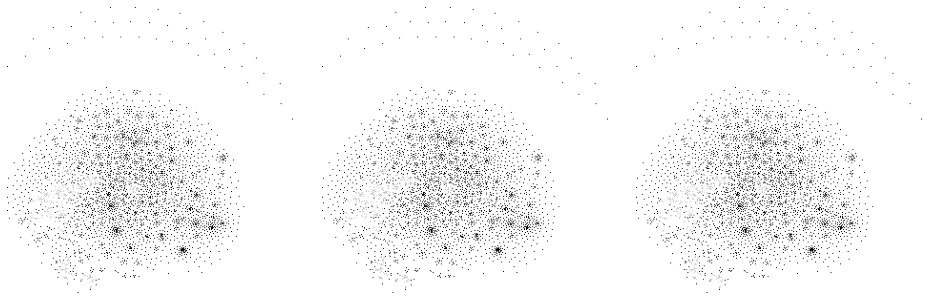

In [11]:
# Re-run this cell to show a new batch of images

images, classes = next(train_sample_iterator)

display_nine_images(images)

In [12]:
def create_model(classes=N_CLASSES):

  base_model = EfficientNetB3(
      input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS), 
      weights='noisy-student', 
      include_top=False)

  inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
  x = base_model(inputs)
  x.trainable = True
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  outputs = Dense(N_CLASSES, activation='sigmoid')(x)
  model = keras.Model(inputs, outputs)

  model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
  )
  
  return model

In [13]:
# creating the model within the TPUStrategy scope to utilise TPU

with tpu_strategy.scope(): 
  model = create_model()
print(model.summary())

43941888/43933088 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnet-b3 (Functional  (None, 10, 10, 1536)     10783528  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 185)               284345    
                                                              

In [14]:
print("TRAINING IMAGES: ", N_TRAIN, ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", N_VALID)

TRAINING IMAGES:  13265 , STEPS PER EPOCH:  51
VALIDATION IMAGES:  3316


In [15]:
def train_model(model=None, data=train_ds, val=val_ds, epochs=EPOCHS, train_steps=TRAIN_STEPS, batch_size=BATCH_SIZE):

  # define learning rates for learning rate scheduler
  start_lr = 0.00001
  min_lr = 0.00001
  max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
  rampup_epochs = 5
  sustain_epochs = 0
  exp_decay = .8

  # function for lr_callback
  def lrfn(epoch):
    if epoch < rampup_epochs:
      return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
      return max_lr
    else:
      return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

  # define callbacks
  lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

  # fit model
  history = model.fit(data,
                      batch_size=BATCH_SIZE, 
                      validation_data=val, 
                      steps_per_epoch=train_steps, 
                      epochs=epochs, 
                      callbacks=[lr_callback])
  
  def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

  plt.subplots(figsize=(10,10))
  plt.tight_layout()

  display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
  display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)
  
  plt.savefig('noisystudent_training_curves.svg')
  
  return history


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/100
51/51 [==============================] - 270s 3s/step - loss: 0.6548 - accuracy: 0.0062 - val_loss: 0.7018 - val_accuracy: 0.0015 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/100
51/51 [==============================] - 139s 3s/step - loss: 0.2924 - accuracy: 0.0136 - val_loss: 0.5202 - val_accuracy: 0.0018 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/100
51/51 [==============================] - 115s 2s/step - loss: 0.0513 - accuracy: 0.0605 - val_loss: 0.3041 - val_accuracy: 0.0018 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/100
51/51 [==============================] - 98s 2s/step - loss: 0.0297 - accuracy: 0.0767 - val_loss: 0.2376 - val_accuracy: 0.0775 - lr: 2.4400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/100
51/51 [===============

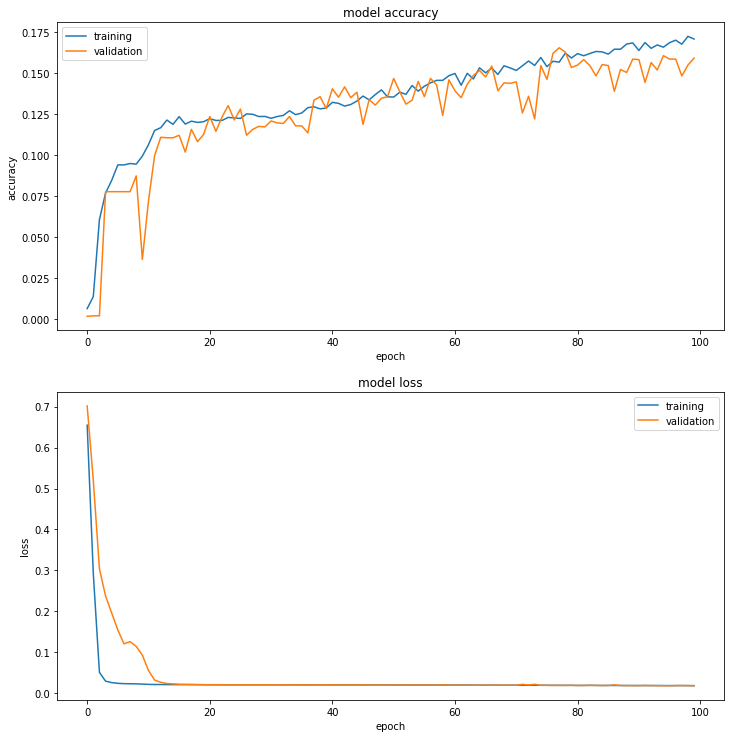

In [16]:
train_model(model)

In [17]:
# Evaluate the model on the test dataset

results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

28/28 [==============================] - 58s 1s/step - loss: 0.0185 - accuracy: 0.1717
test loss, test acc: [0.018451150506734848, 0.17166174948215485]


In [18]:
# Save trained model and training curves
model.save('effnetb3_noisystudent_bs256.h5')
files.download('effnetb3_noisystudent_bs256.h5')
files.download('effnetb3_noisystudent_bs256.h5')

# upload to GCS bucket
#!gsutil -m cp /content/effnetb3_noisystudent_bs256.h5 gs://{BUCKET_NAME}/capstone_trained_models/
#!gsutil -m cp /content/noisystudent_training_curves.svg gs://{BUCKET_NAME}/capstone_trained_models/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Predict classes
predictions = model.predict(test_ds, batch_size=BATCH_SIZE)
print("predictions shape:", predictions.shape)

predictions shape: (7107, 185)


In [20]:
# Create empty dataframe to append predictions to
cols = np.arange(185).tolist()
preds_df = pd.DataFrame(columns=cols)

# Append predictions to dataframe
for pred in predictions:
  preds_df = preds_df.append(pd.DataFrame(pred.reshape(1,-1), columns=cols), ignore_index=True)

# Convert dataframe to csv file
preds_df.to_csv('effnetb3_noisystudent_bs256_predictions.csv')

In [21]:
# download and upload predictions to GCS bucket
files.download('effnetb3_noisystudent_predictions.csv')
!gsutil -m cp /content/effnetb3_noisystudent_predictions.csv gs://{BUCKET_NAME}/capstone_results/

FileNotFoundError: ignored

In [ ]:
x = preds_df.values
print('MIN pred',np.min(x),'MAX pred',np.max(x))
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.hist( x[x<0.2], bins=50)
plt.subplot(1,2,2)
plt.hist( x[x>0.8], bins=50)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(x[x>0.1], bins=50)
plt.gca().set_title('Predicted Class Probabilities', fontsize=14)

plt.show()

#plt.savefig('class_probabilities.svg', bbox='tight')

#files.download('class_probabilities.svg')